In [1]:
from typing import Tuple

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import utils as u
from models import pentzer2014pow
from models.DL import terrain_MLP as tmlp
from steps import preprocess
from visualization import papermode

# papermode(plt, size=12)


In [2]:
terrain_abbrs = u.import_terrain_abbrs_yaml(("Vegetal", "Asphalt", "Snow"))
# terrain_abbrs = u.import_terrain_abbrs_yaml()
abbrs = sorted([item for sublist in terrain_abbrs.values() for item in sublist])

In [3]:
dfs = {}
for abbr in abbrs:
    pentz_df = pentzer2014pow.open_pentzer2014pow_df(abbr);
    dfs[abbr] = pentz_df
    dfs[abbr]["mass"] = pentz_df.meta.ugv_mass
    dfs[abbr]["terrain"] = u.get_terrain(abbr).lower()

In [4]:
veloc = ("vx", "vy", "vz")
accel = ("ax", "ay", "az")
acc_cor = ("ax_corr", "ay_corr", "az_corr")
posit = ("px", "py", "pz")
volts = ("V_L", "V_R")
wheel = ("vL", "vR")
morales = ("JS_sym", "JG")
amps = ("I_L", "I_R")

cols_x = [
    "mass",
    # *veloc,
    # *acc_cor,
    # *posit,
    *volts,
    *wheel,
    *morales,
    *amps,
]

cols_y = ["P_motion", "terrain"]

In [5]:
terrain_abbrs["snow"]

['D05', 'D06', 'D09', 'D13', 'D14', 'R02', 'R03', 'R09']

In [6]:
terrain_dfs = {}
for terr, terr_abbrs in terrain_abbrs.items():
    terr_dfs = [dfs[abbr] for abbr in terr_abbrs]
    terrain_dfs[terr] = pd.concat(terr_dfs, ignore_index=True)
    terrain_dfs[terr]["terrain"] = terr

terr_df = pd.concat(terrain_dfs.values(), ignore_index=True)
terr_df = terr_df[cols_x + cols_y].copy().dropna()

In [7]:

X = terr_df[cols_x].copy()
y = terr_df[cols_y].copy()
terrains = [*terrain_dfs.keys()]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
# ter_mlp = tmlp.TerrainMLPRegressor(terrains=terrains, shuffle=True, hidden_layer_sizes=(16, 8, 5), max_iter=500, verbose=False)
ter_mlp = tmlp.TerrainMLPRegressor(terrains=terrains, shuffle=True, max_iter=500)
ter_mlp.fit(X_train, y_train)

Snow:  67%|██████▋   | 2/3 [00:24<00:12, 12.99s/it]   /home/norlab/code/202206/terrain-code/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
Snow: 100%|██████████| 3/3 [01:33<00:00, 31.19s/it]


In [9]:
ter_mlp.score(X_test, y_test)

0.6610169491525424

In [16]:
y_pred = ter_mlp.predict(X_test, y_test.P_motion)
terr_pred = [terrains[idx] for idx in y_pred]
disp = ter_mlp.confusion_matrix(y_test.terrain, terr_pred, normalization="true")

['mass', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


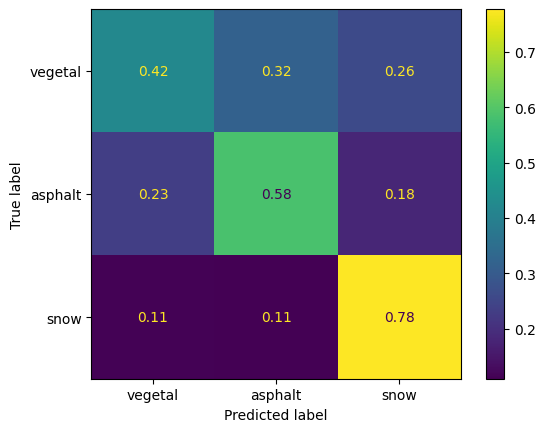

In [17]:
print(cols_x)
disp.plot();

In [ ]:
model_name = tmlp.__MODEL_NAME__.lower()
figdir = u.get_figdir("summary", subdir=model_name)
model_name = tmlp.__MODEL_NAME__.title()
for ext in u.EXTS:
    disp.figure_.savefig(figdir / f"terrainMLP_3classes.{ext}", bbox_inches="tight")

In [19]:
from sklearn.metrics import precision_recall_fscore_support
_, recall, _, _ = precision_recall_fscore_support(y_test.terrain, terr_pred)
recall

array([0.58454545, 0.77696859, 0.42237762])

In [ ]:
pred_proba = ter_mlp.predict_proba(X_test, y_test.P_motion)
for terr in pred_proba.columns.values:
    errabs = pred_proba[terr].abs()
    print(terr)
    print("min", errabs.min(), errabs.argmin())
    print("max", errabs.max(), errabs.argmax())

In [ ]:
from pathlib import Path
import joblib
saved_path = Path("data") / "saved_models"
for terrain, mdl in zip(terrains, ter_mlp.models):
    fname = saved_path / f"{terrain}.mdl"
    joblib.dump(mdl, fname)
    